# Оптимизация маркетинговых затрат

## Изучение данных и подготовка к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info.csv'),  # покупки
    pd.read_csv('/datasets/costs_info.csv'),  # траты на рекламу
)

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [6]:
visits = visits.rename(columns={"User Id": "user_id", "Region": "region", "Device": "device",
                      "Channel": "channel", "Session Start": "session_start", "Session End": "session_end"})

In [7]:
orders = orders.rename(columns={"User Id": "user_id", "Event Dt": "event_dt", "Revenue": "revenue"})

In [8]:
costs = costs.rename(columns={"Channel": "channel"})

In [9]:
time_format = '%d.%m.%Y %H:%M'

In [10]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format = time_format)
visits['session_end'] = pd.to_datetime(visits['session_end'], format = time_format)
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [11]:
visits.duplicated().sum()

0

In [12]:
orders.duplicated().sum()

0

In [13]:
costs.duplicated().sum()

0

In [14]:
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00
2,590706206550,United States,Mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:00,2019-05-01 00:54:00
4,349773784594,United States,Mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00


In [15]:
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [16]:
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


### Вывод

В нашем распоряжении три таблицы с данными: пользовательские сессии, покупки и данные о рекламных расходах. В каждой таблице названия столбцов содержали заглавные буквы и пробелы, поэтому мы их переименовали. Во всех таблицах даты привели к формату дат. Теперь тип данных во всех колонках соответствует значениям, дубликатов нет.

## Исследовательский анализ данных

Получим профили пользователей. Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках, событиях и тратах на рекламу.

In [17]:
def get_profiles(sessions, orders, ad_costs):

    profiles = (
        # сортируем сессии по ID пользователя и дате посещения
        sessions.sort_values(by=['user_id', 'session_start'])
        # группируем по ID
        .groupby('user_id')
        # для каждого пользователя находим
        .agg(
            {
                'session_start': 'first',   # время первого посещения
                'channel': 'first',  # источник первого перехода
                'device': 'first',  # устройство при первом посещении
                'region': 'first',  # страну при первом посещении
            }
        )
        # столбец с временем первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        # возвращаем данные из индексов в столбцы
        .reset_index()
    )

    # добавляем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак совершения покупки
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(
        0
    )
    
    return profiles  # возвращаем профили с CAC 

In [18]:
profiles = get_profiles(visits, orders, costs)

In [19]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Найдём минимальную и максимальную даты привлечения пользователей:

In [20]:
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()
print('Минимальная дата привлечения пользователей:', min_analysis_date)
print('Максимальная дата привлечения пользователей:', max_analysis_date)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?


In [24]:
profiles.groupby('region').agg({'user_id': 'count', 'payer': 'mean'}).sort_values(
    'payer', ascending = False).style.format({'payer': '{:,.2%}'.format})

,user_id,payer
region,,
United States,100002,6.90%
Germany,14981,4.11%
UK,17575,3.98%
France,17450,3.80%


- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?

In [22]:
profiles.groupby('device').agg({'user_id': 'count', 'payer': 'mean'}).sort_values(
    'payer', ascending = False).style.format({'payer': '{:,.2%}'.format})


,user_id,payer
device,,
Mac,30042,6.36%
iPhone,54479,6.21%
Android,35032,5.85%
PC,30455,5.05%


- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [23]:
profiles.groupby('channel').agg({'user_id': 'count', 'payer': 'mean'}).sort_values(
    'payer', ascending = False).style.format({'payer': '{:,.2%}'.format})

,user_id,payer
channel,,
FaceBoom,29144,12.20%
AdNonSense,3880,11.34%
lambdaMediaAds,2149,10.47%
TipTop,19561,9.60%
RocketSuperAds,4448,7.91%
WahooNetBanner,8553,5.30%
YRabbit,4312,3.83%
MediaTornado,4364,3.57%
LeapBob,8553,3.06%


In [ ]:
profiles.pivot_table(index='channel', columns = 'region', values='user_id', aggfunc='count')

### Вывод

С помощью готовой функции мы получили пользовательские профили — таблицу profiles с деталями первого посещения каждого пользователя, такими как источник перехода на сайт, страна, устройство.
Минимальная и максимальная даты привлечения пользователей: с 1 мая по 27 октября 2019 года. 
В приложение приходит больше всего пользователей из США. Доля платящих пользователей тоже больше всего в США (6,9%). Из Франции и Англии приходит примерно одинаковое количество пользователей, но доля платящих в этих странах ниже, чем в Германии, из которой приходит наименьшее количество пользователей.
Большинство пришедших пользователей (54479) - пользователи iPhone. Затем идут пользователи Android, PC и меньше всего пользователей Mac (30342). Однако доля платящих для Mac самая высокая - 6,4%. 
Пользователи приходили из 10 рекламных каналов. Больше всего пришло пользователей со значительным отравом из FaceBoom (29144) и TipTop (19561). Доля платящих самая высокая у пользователей FaceBoom - 12%.
В США использовались для привлечения источники трафика - FaceBoom, MediaTornado, RocketSuperAds, TipTop, YRabbit.
В Европейских странах - AdNonSense, LeapBob, OppleCreativeMedia, WahooNetBanner, lambdaMediaAds.

## Расчёт метрик и графики

### Продукт:
-    Сколько людей пользуются в день, неделю, месяц?

In [25]:
visits['session_month'] = visits['session_start'].astype('datetime64[M]')
visits['session_week'] = visits['session_start'].astype('datetime64[W]')
visits['session_date'] = visits['session_start'].dt.date

In [26]:
visits.head()

,user_id,region,device,channel,session_start,session_end,session_month,session_week,session_date
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00,2019-05-01,2019-04-25,2019-05-01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00,2019-05-01,2019-04-25,2019-05-01
2,590706206550,United States,Mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00,2019-05-01,2019-04-25,2019-05-01
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:00,2019-05-01 00:54:00,2019-05-01,2019-04-25,2019-05-01
4,349773784594,United States,Mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00,2019-05-01,2019-04-25,2019-05-01


In [27]:
dau = visits.groupby('session_date').agg({'user_id': 'nunique'})
wau = visits.groupby('session_week').agg({'user_id': 'nunique'})
mau =  visits.groupby('session_month').agg({'user_id': 'nunique'})

print('DAU за весь период', int(dau.mean()), 'пользователей')
print('WAU за весь период', int(wau.mean()), 'пользователей')
print('MAU за весь период', int(mau.mean()), 'пользователей')

DAU за весь период 1684 пользователей
WAU за весь период 7942 пользователей
MAU за весь период 28989 пользователей


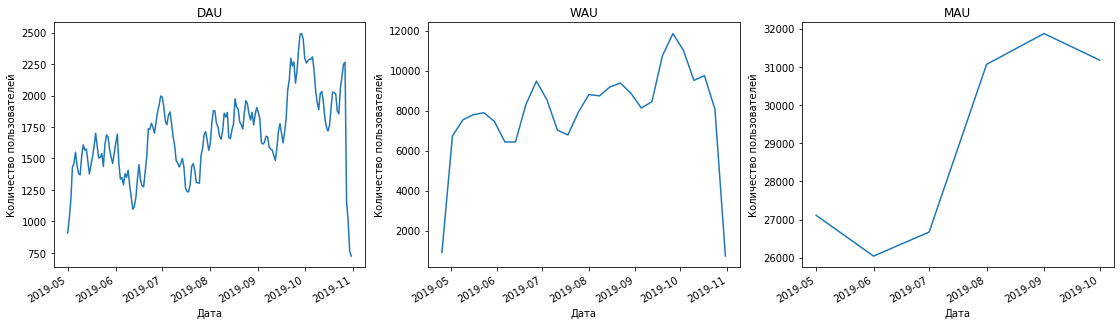

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(19,5))
ax[0].plot(dau)
ax[0].set(title = 'DAU', xlabel = 'Дата', ylabel = 'Количество пользователей')
ax[1].plot(wau)
ax[1].set(title = 'WAU', xlabel = 'Дата', ylabel = 'Количество пользователей')
ax[2].plot(mau)
ax[2].set(title = 'MAU', xlabel = 'Дата', ylabel = 'Количество пользователей')
fig.autofmt_xdate(rotation=30)
plt.show()

По графикам видно, что в августе, сентябре и октябре посещаемость приложения значительно выросла - более 31000 пользователей ежемесячно.

-    Сколько сессий в день?

In [30]:
sess_per_user = visits.groupby('session_date').agg({'user_id': ['count', 'nunique']})
sess_per_user.columns = ['n_sessions', 'n_users']
sess_per_user['sess_per_user'] = (sess_per_user['n_sessions'] / sess_per_user['n_users'])
sess_per_user.head()

,n_sessions,n_users,sess_per_user
session_date,,,
2019-05-01,909,909,1.0
2019-05-02,1026,1026,1.0
2019-05-03,1170,1170,1.0
2019-05-04,1429,1429,1.0
2019-05-05,1463,1463,1.0


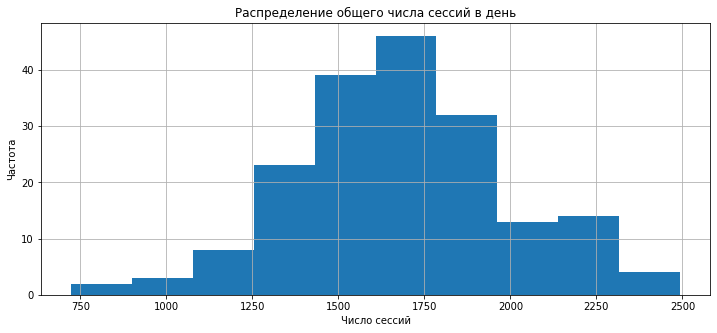

In [31]:
plt.figure(figsize= (12,5))
sess_per_user['n_users'].hist().set(
    title = 'Распределение общего числа сессий в день', xlabel = 'Число сессий', ylabel = 'Частота')
plt.show()

In [32]:
sess_per_user['n_users'].mean()

1684.2391304347825

Среднее количество сессий в день не отличается от количества пользователей в день. Получается, что каждый пользователь заходит в приложение не чаще 1 раза в день.

-    Сколько длится одна сессия?

In [33]:
# считаем ASL
visits['session_duration_sec'] = (visits['session_end'] - visits['session_start']).dt.total_seconds()
visits['session_duration_sec'].describe()

count    309901.000000
mean       1800.084801
std        1803.189827
min           0.000000
25%         540.000000
50%        1260.000000
75%        2520.000000
max       22260.000000
Name: session_duration_sec, dtype: float64

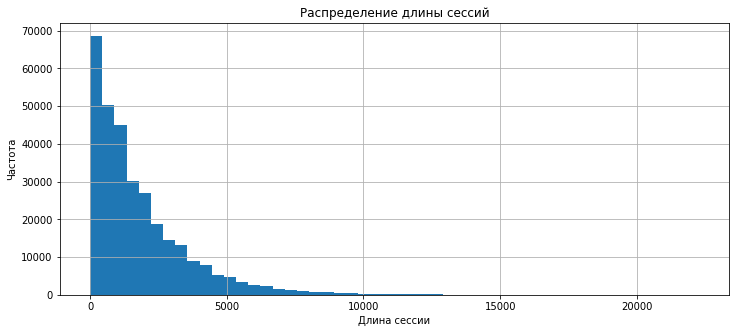

In [34]:
plt.figure(figsize= (12,5))
visits['session_duration_sec'].hist(bins=50).set(
    title = 'Распределение длины сессий', xlabel = 'Длина сессии', ylabel = 'Частота')
plt.show()

In [35]:
visits['session_duration_sec'].describe()

count    309901.000000
mean       1800.084801
std        1803.189827
min           0.000000
25%         540.000000
50%        1260.000000
75%        2520.000000
max       22260.000000
Name: session_duration_sec, dtype: float64

Медианная длительность сессии 1260 секунд (21 минута).

### Продажи:

- Когда люди начинают покупать?

Найдём с помощью таблицы покупок для каждого пользователя дату и время первой покупки.

In [36]:
first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

In [37]:
first_orders

,user_id,event_dt
0,599326,2019-05-07 20:59:09
1,46006712,2019-06-30 03:46:52
2,374052872,2019-08-16 07:44:47
3,414791703,2019-05-04 18:06:41
4,785077127,2019-06-30 18:35:15
...,...,...
8876,999625937544,2019-10-26 06:24:27
8877,999645428220,2019-10-01 05:36:23
8878,999659859721,2019-09-08 01:28:08
8879,999779032958,2019-07-05 23:28:13


Добавим к получившейся таблице информацию о дате и времени первого посещения для каждого пользователя.
И рассчитаем среднию разницу во времени между первым посещением и первой покупкой в секундах.

In [38]:
result = profiles.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

In [39]:
result_time = (result['event_dt'] - result['first_ts']).dt.total_seconds() // 60

In [40]:
result_time.mean()

2711.353338587997

В среднем с момента первого посещения до покупки проходит 2711 секунд, те 45 минут.

- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?

Добавим в таблицу покупок столбцы с месяцем и неделей покупки, будем группировать по периодам, считать выручку и делить на количество покупок за период. 

In [41]:
report = orders.copy()
report['dt_month'] = report['event_dt'].astype('datetime64[M]')
report['dt_week'] = report['event_dt'].astype('datetime64[W]')
report['dt'] = report['event_dt'].dt.date
report_d = report.groupby('dt').agg({'user_id': 'nunique', 'event_dt': 'count'})
report_d.columns = ['buyers', 'orders']
report_d['orders_per_buyer'] = report_d['orders'] / report_d['buyers']
orders_per_day = report_d.drop(['buyers', 'orders'], axis=1)
print('В день платящий пользователь в среднем делает', report_d['orders_per_buyer'].mean(), 'покупок')

В день платящий пользователь в среднем делает 1.0000345022303812 покупок


In [42]:
report_w = report.groupby(['dt_week']).agg({'user_id': 'nunique', 'event_dt': 'count'})
report_w.columns = ['buyers', 'orders']
report_w['orders_per_buyer'] = report_w['orders'] / report_w['buyers']
orders_per_week = report_w.drop(['buyers', 'orders'], axis=1)
print('В неделю платящий пользователь в среднем делает', report_w['orders_per_buyer'].mean(), 'покупок')

В неделю платящий пользователь в среднем делает 1.3161715525537907 покупок


In [43]:
report_m = report.groupby(['dt_month']).agg({'user_id': 'nunique', 'event_dt': 'count'})
report_m.columns = ['buyers', 'orders']
report_m['orders_per_buyer'] = report_m['orders'] / report_m['buyers']
orders_per_month = report_m.drop(['buyers', 'orders'], axis=1)
print('В месяц платящий пользователь в среднем делает', report_m['orders_per_buyer'].mean(), 'покупок')

В месяц платящий пользователь в среднем делает 2.228447784645054 покупок


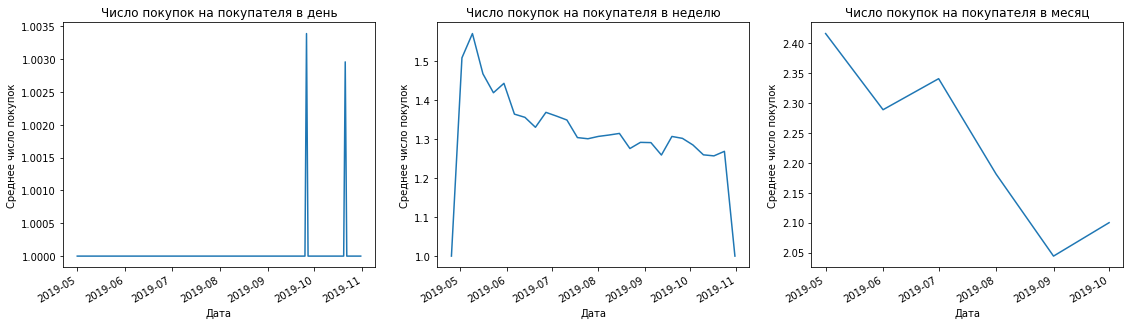

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(19,5))
ax[0].plot(orders_per_day)
ax[0].set(title = 'Число покупок на покупателя в день', xlabel = 'Дата', ylabel = 'Среднее число покупок')
ax[1].plot(orders_per_week)
ax[1].set(title = 'Число покупок на покупателя в неделю', xlabel = 'Дата', ylabel = 'Среднее число покупок')
ax[2].plot(orders_per_month)
ax[2].set(title = 'Число покупок на покупателя в месяц', xlabel = 'Дата', ylabel = 'Среднее число покупок')
fig.autofmt_xdate(rotation=30)
plt.show()

Число покупок на покупателя в месяц стабильно снижалось с июля по сентябрь.

- Какой средний чек за месяц, неделю, день?

In [45]:
report

,user_id,event_dt,revenue,dt_month,dt_week,dt
0,188246423999,2019-05-01 23:09:52,4.99,2019-05-01,2019-04-25,2019-05-01
1,174361394180,2019-05-01 12:24:04,4.99,2019-05-01,2019-04-25,2019-05-01
2,529610067795,2019-05-01 11:34:04,4.99,2019-05-01,2019-04-25,2019-05-01
3,319939546352,2019-05-01 15:34:40,4.99,2019-05-01,2019-04-25,2019-05-01
4,366000285810,2019-05-01 13:59:51,4.99,2019-05-01,2019-04-25,2019-05-01
...,...,...,...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99,2019-10-01,2019-10-31,2019-10-31
40208,275341387049,2019-10-31 01:17:17,4.99,2019-10-01,2019-10-31,2019-10-31
40209,374656616484,2019-10-31 06:17:29,4.99,2019-10-01,2019-10-31,2019-10-31
40210,168548862926,2019-10-31 22:46:19,4.99,2019-10-01,2019-10-31,2019-10-31


In [46]:
check_avg_d = report.groupby('dt').agg({'event_dt': 'count', 'revenue': 'sum',})
check_avg_d.columns = ['orders', 'revenue_sum']
check_avg_d['average_check'] = check_avg_d['revenue_sum'] / check_avg_d['orders']
check_d = check_avg_d.drop(['orders', 'revenue_sum'], axis=1)
print('Средний чек за день', check_d['average_check'].mean())

Средний чек за день 5.375884247160584


In [47]:
check_avg_w = report.groupby('dt_week').agg({'event_dt': 'count', 'revenue': 'sum',})
check_avg_w.columns = ['orders', 'revenue_sum']
check_avg_w['average_check'] = check_avg_w['revenue_sum'] / check_avg_w['orders']
check_w = check_avg_w.drop(['orders', 'revenue_sum'], axis=1)
print('Средний чек за неделю', check_w['average_check'].mean())

Средний чек за неделю 5.363434790693549


In [48]:
check_avg_m = report.groupby('dt_month').agg({'event_dt': 'count', 'revenue': 'sum',})
check_avg_m.columns = ['orders', 'revenue_sum']
check_avg_m['average_check'] = check_avg_m['revenue_sum'] / check_avg_m['orders']
check_m = check_avg_m.drop(['orders', 'revenue_sum'], axis=1)
print('Средний чек за месяц', check_m['average_check'].mean())

Средний чек за месяц 5.374169416181577


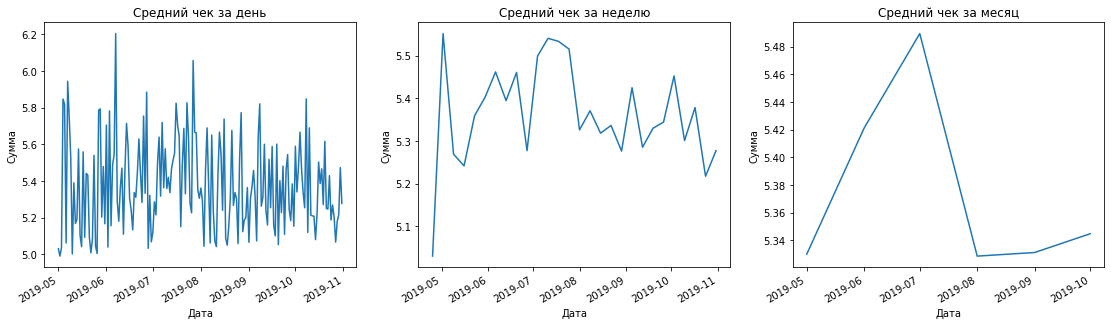

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(19,5))
ax[0].plot(check_d)
ax[0].set(title = 'Средний чек за день', xlabel = 'Дата', ylabel = 'Сумма')
ax[1].plot(check_w)
ax[1].set(title = 'Средний чек за неделю', xlabel = 'Дата', ylabel = 'Сумма')
ax[2].plot(check_m)
ax[2].set(title = 'Средний чек за месяц', xlabel = 'Дата', ylabel = 'Сумма')
fig.autofmt_xdate(rotation=30)
plt.show()

Средний чек за месяц рос в период с мая по июль, достиг своего пика и начал снижаться до значения в начале периода. Потом незначительно рос.

### Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени

Добавим в таблицу с рекламными расходами столбцы с указанием недели и месяца.

In [50]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs['week'] = costs['dt'].astype('datetime64[W]')

In [51]:
costs

,dt,channel,costs,month,week
0,2019-05-01,FaceBoom,113.3,2019-05-01,2019-04-25
1,2019-05-02,FaceBoom,78.1,2019-05-01,2019-05-02
2,2019-05-03,FaceBoom,85.8,2019-05-01,2019-05-02
3,2019-05-04,FaceBoom,136.4,2019-05-01,2019-05-02
4,2019-05-05,FaceBoom,122.1,2019-05-01,2019-05-02
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,2019-10-01,2019-10-17
1796,2019-10-24,lambdaMediaAds,6.4,2019-10-01,2019-10-24
1797,2019-10-25,lambdaMediaAds,8.8,2019-10-01,2019-10-24
1798,2019-10-26,lambdaMediaAds,8.8,2019-10-01,2019-10-24


In [52]:
costs['costs'].sum()

105497.30000000002

In [53]:
costs.groupby('month').agg({'costs': 'sum'})

,costs
month,
2019-05-01,9978.570
2019-06-01,15090.045
2019-07-01,16447.060
2019-08-01,20657.870
2019-09-01,22441.340
2019-10-01,20882.415


In [54]:
costs.groupby(['channel']).agg({'costs': 'sum'})

,costs
channel,
AdNonSense,3911.25
FaceBoom,32445.60
LeapBob,1797.60
MediaTornado,954.48
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
TipTop,54751.30
WahooNetBanner,5151.00
YRabbit,944.22


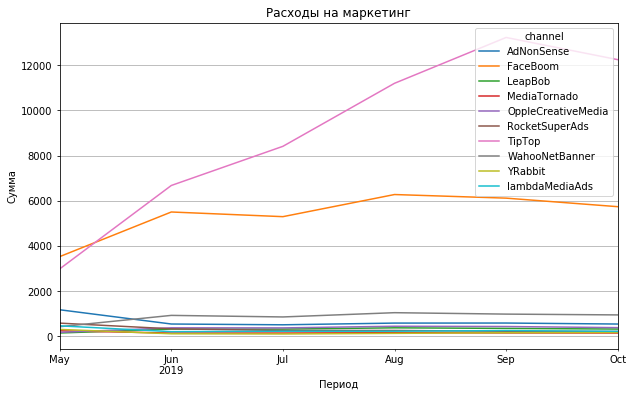

In [55]:
costs.pivot_table(
    index='month', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, figsize=(10, 6))
plt.ylabel('Сумма')
plt.xlabel('Период')
plt.title('Расходы на маркетинг')
plt.show() 

Больше всего расходов было на источники TipTop и FaceBoom. Расходы на TipTop постоянно росли и к сентябрю были уже в два раза больше, чем на FaceBoom.

- Сколько в среднем стоило привлечение одного пользователя из каждого источника?

In [56]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:00,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:00,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:00,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:00,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [57]:
profiles.groupby(['channel']).agg({'acquisition_cost': 'mean'}).sort_values('acquisition_cost', ascending = False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Самая большая стоимость покупателя оказалась для источника TipTop. Более, чем в два раза дешевле, но всё равно дороже чем остальные - покупатель из FaceBoom.

### Вывод

Согласно изменениям метрик во времени наблюдается увеличение количества пользователей приложения благодаря привлючению с помощью рекламы. Начиная с июля посещаемость приложения выросла, однако снизились такие показатели как число покупок на покупателя и средний чек. Были крупные рекламные вложения в два источника привлечения - FaceBoom и TipTop, в последнем случае расходы постоянно росли на протяжении всего периода.

## Функции для расчёта и визуализации LTV, ROI, удержания и конверсии

Соберём функции для создания профилей, расчёта удержания, конверсии, LTV и ROI: get_profiles(), get_retention(), get_conversion() и get_ltv()

In [58]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [59]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [60]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # что мы здесь делаем???
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

А также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi()

In [61]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [62]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [63]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [64]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Установим момент и горизонт анализа данных. На календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

In [65]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Исключим из расчётов пользователей, пришедших из поисковых систем, тк с каналом organic, поскольку они приходят сами, бесплатно.

In [66]:
profiles = profiles.query('channel != "organic"')

## Оценка окупаемости рекламы

### Общая окупаемость рекламы

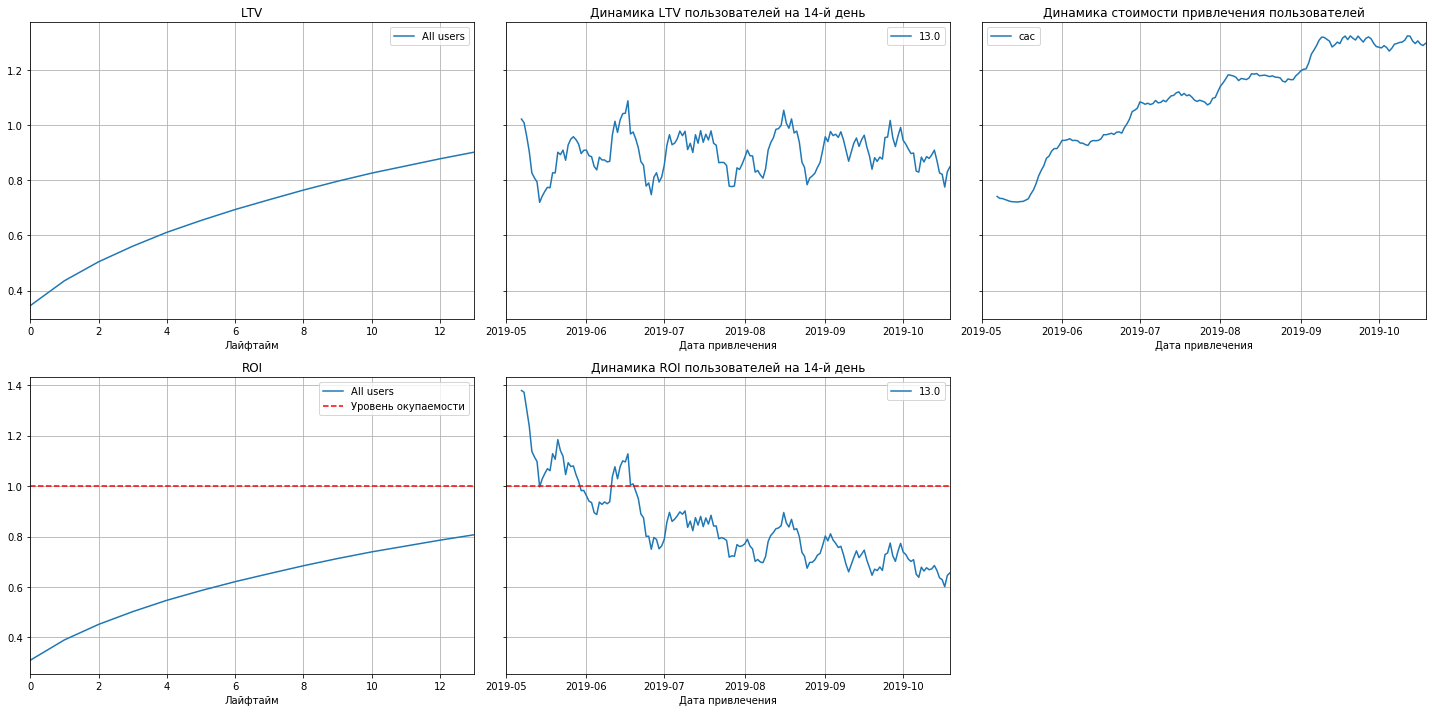

In [67]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:
- Реклама не окупается. ROI в конце второй недели только 80%.
- CAC постоянно растёт, самый высокий CAC примерно после второй недели сентябля и до конца периода.
- LTV достаточно стабилен.
- ROI 14-го дня показывает, что реклама окупалась в мае, а с июня стабльное снижение

### Окупаемость рекламы с разбивкой по рекламным каналам

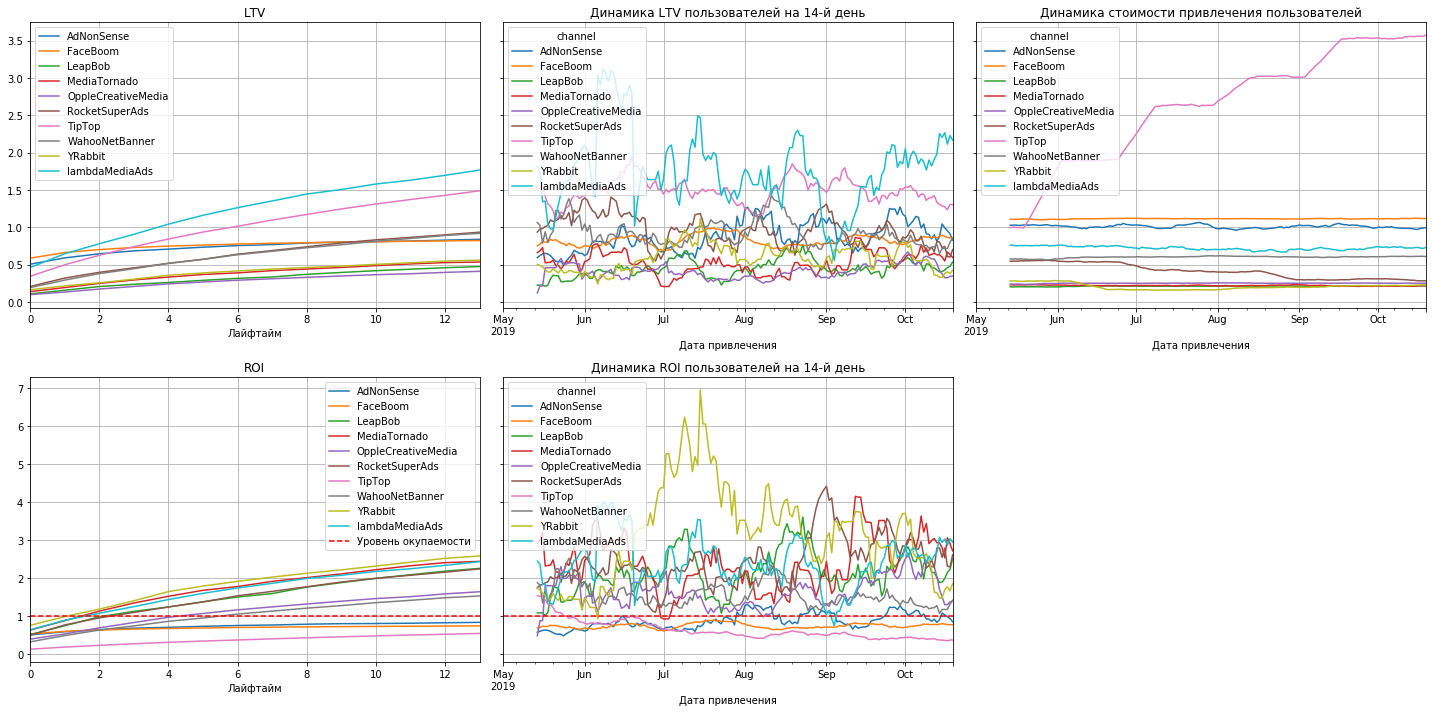

In [68]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

- Самый высоких LTV - у пользователей из lambdaMediaAds, затем идёт TipTop.
- Стоимость привлечения пользователей из TipTop с течением времени росла скачкообразно и в разы выше стоимости для остальных источников. С остальными источниками стоимость была стабильна либо почти стабильна.
- Пользователи, привлеченные из большинства каналов превышают порог окупаемости, что нельзя сказать о трёх каналах: АdNonSense, FaceBoom и TipTop. Хуже всего обстоит дело с пользователями из TipTop.
- Динамика окупаемости 14-го дня показывает, что новые пользователи из FaceBoom и TipTop не окупались стабильно, а из АdNonSense новые пользователя привлеченные в начале августа и в конце сентября окупались на 14-й день.

Пользователи из TipTop принесли больше всего выручки, но стоимость привлечения для них настолько высокая, что они не окупаются. Пользователи из  АdNonSense, FaceBoom стоят намного дешевле, чем из TipTop, но дороже, чем из остальных каналов. В следсиве чего они тоже не окупаются.

### Окупаемость рекламы с разбивкой по странам

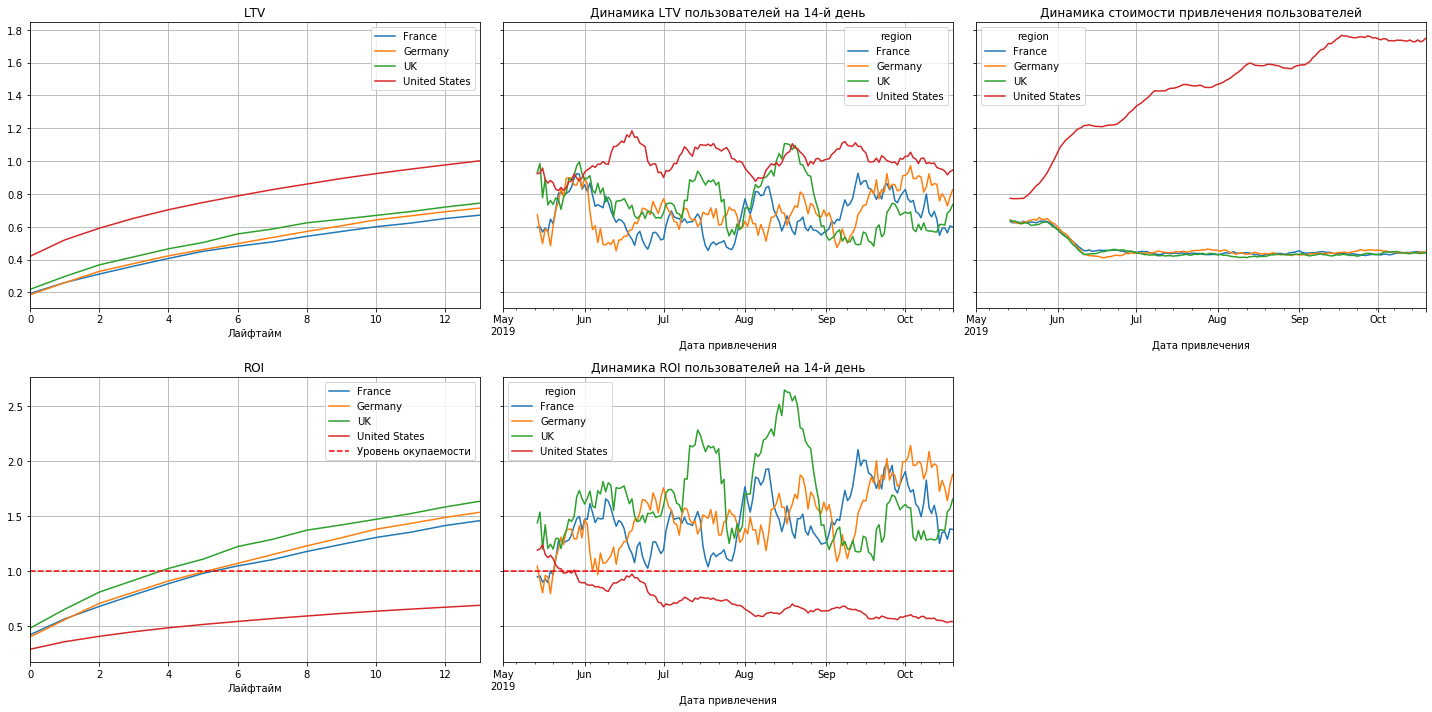

In [69]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

- Самый высокий LTV — у пользователей из США. Затем идут Германия и Англия. Пользователи из Франции приносят магазину меньше всего выручки.
- А вот стоимость привлечения пользователей из США в несколько раз выше и постоянно увеличивалась. Стоимость привлечения для всех остальных стран почти одинаковая и без особых изменений во времени.
- Похоже, что из-за столь больших расходов на привлечение именно пользователи из США не окупаются, в то время как все остальные окупаются уже в середине первой недели.
- Динамика окупаемости 14-го дня показывает, что перестали окупаться пользователи из США, привлечённые начиная с конца мая, как раз когда стоимость привлечения начала расти.

### Окупаемость рекламы с разбивкой по устройствам

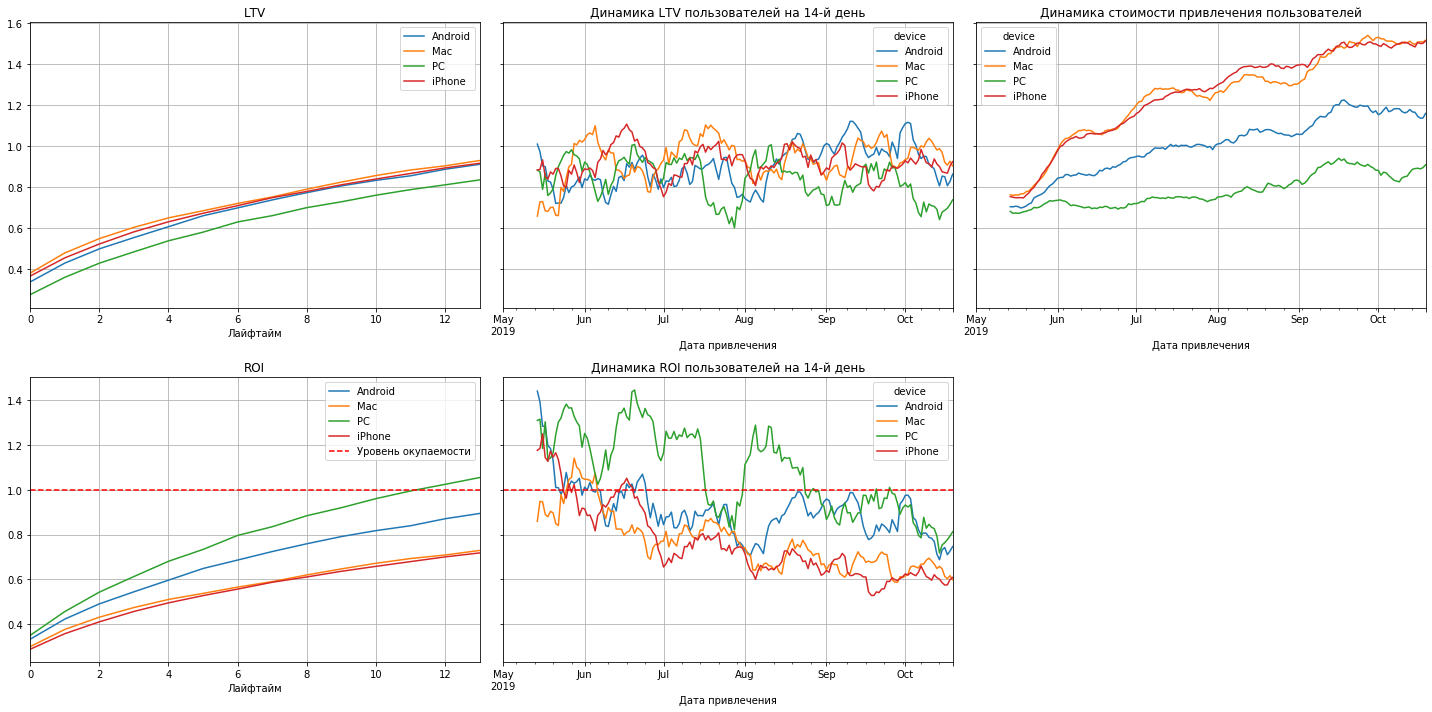

In [70]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

- Самый низкий LTV — у пользователей PC. 
- Cтоимость привлечения пользователей MAC и iPhone выше, чем пользователей другоих устройств.
- Окупаются только пользователи PC, и только к концу второй недели. Окупаемость пользователей Mac и iPhone чуть выше 50%
- Динамика окупаемости 14-го дня показывает, что сентября перестали окупаться пользователи всех устройств. До этого момента пользователи PC окапались большую часть времени

Наблюдается явлная проблема с окупаемостью пользователей в особенности Mac и iPhone. Скорее всего она связана с высокики затратами на привлечение. 

### Графики конверсии и удержания

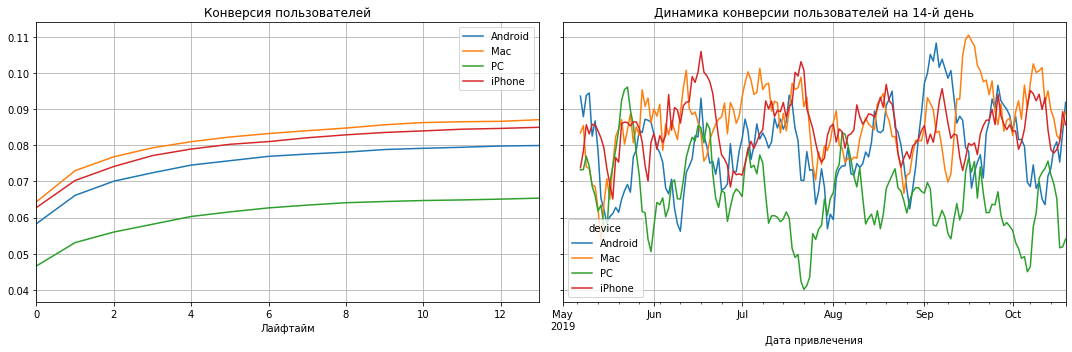

In [71]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, лучше всех конвертируются пользователи Mac и iPhone. Заметно хуже конвертируются пользователи PC.

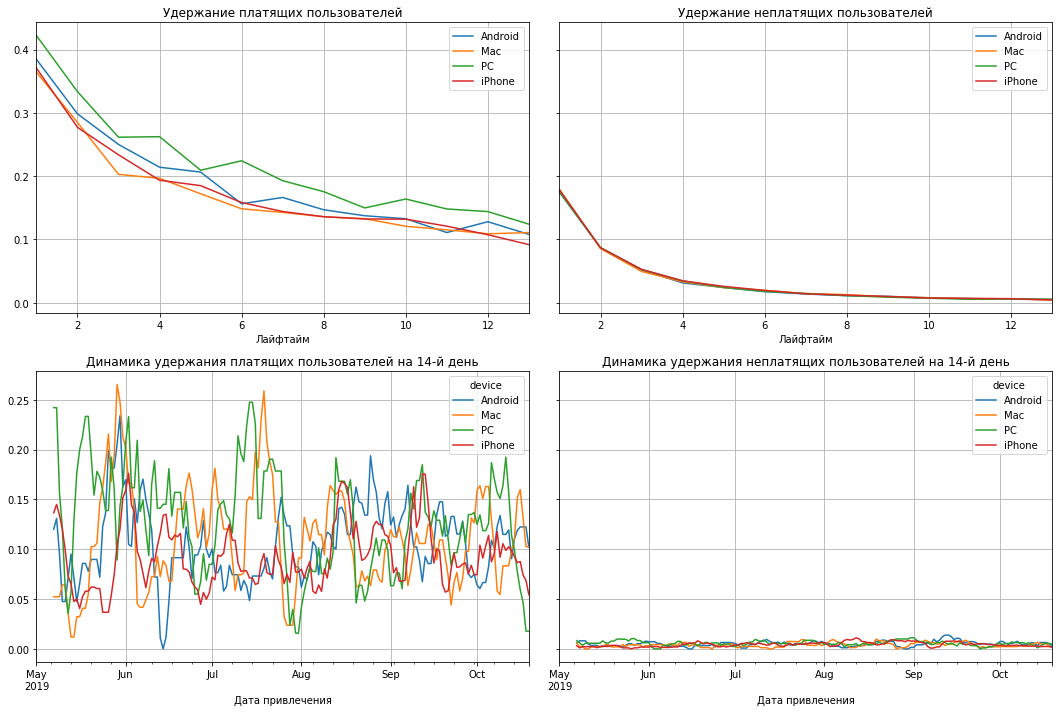

In [72]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей PC выше остальных в течение всех лайфтаймов.
Удержание 14-го дня платящих пользователей на PC выделяется как смое высокое, причем самый высокий показатель удержания был для пользователей, привлечённых в середине мая. На графике сильный пик, затем идет снижение.

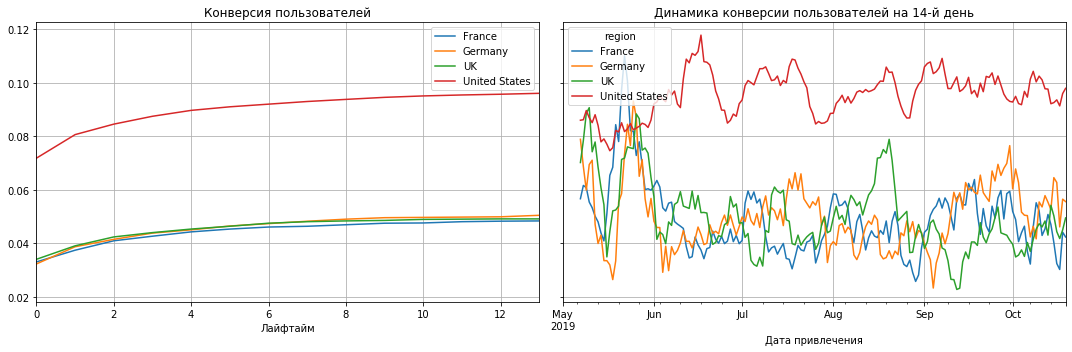

In [73]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи из США конвертируются очень хорошо, значительно лучше пользователей из других стран. Пользователя из США не всегда конвертировались лучше всех. Новые пользователи из Франции в некоторые дни во второй половине мая показывали более высокую конверсию 14-го дня. В начале мая и во второй половине июля пользователи Германии тоже конвертировались достаточно неплохо, однажды даже лучше, чем из США.

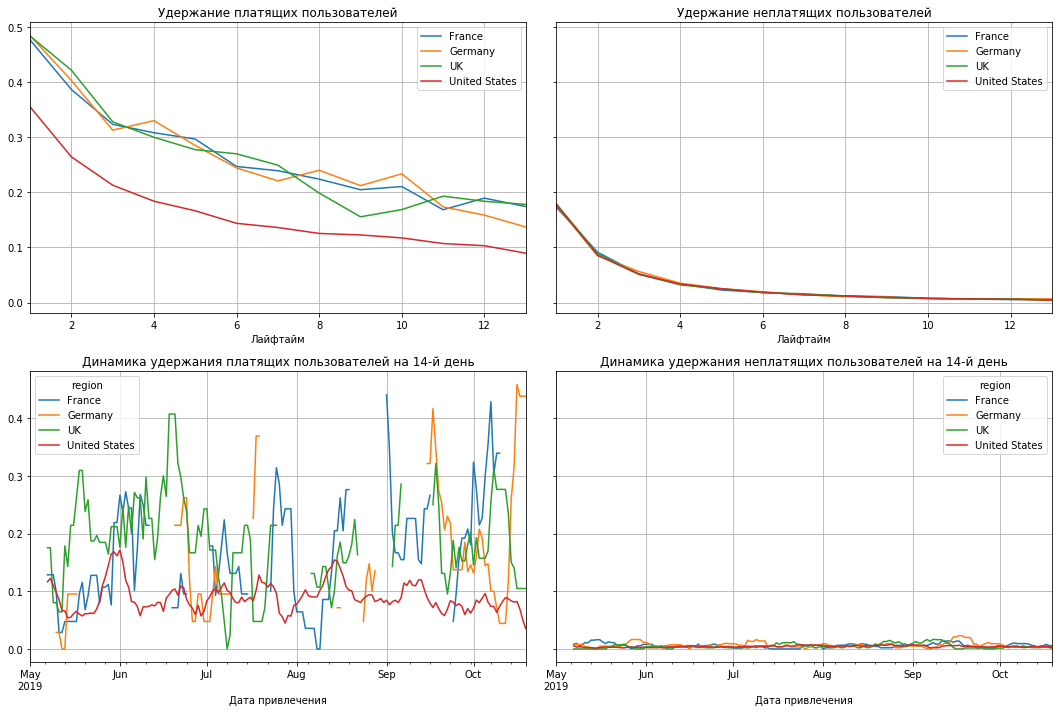

In [74]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Стабильно хуже всех конвертировались пользователи из США. Удержание 14-го дня у них тоже самое низкое. Похоже, что дело не только в стоимости привлечения этих пользователей, но и в удержании.

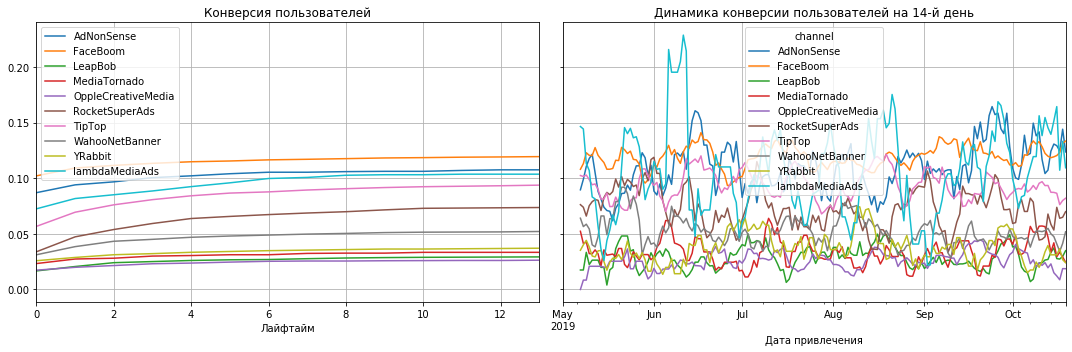

In [75]:
# смотрим конверсию с разбивкой по каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Лучше всего конвертируются пользователи из FaceBoom и Organic. Примерно с 8-го лайфтайма показатель для lambdaMediaAds приближается к Organic. Хуже всех конвертируются пользователи, пришедшие их AdNonSense. На графике конверсии 14-го дня у источника lambdaMediaAds есть несколько пиков, когда покатель выше, чем для остальных.

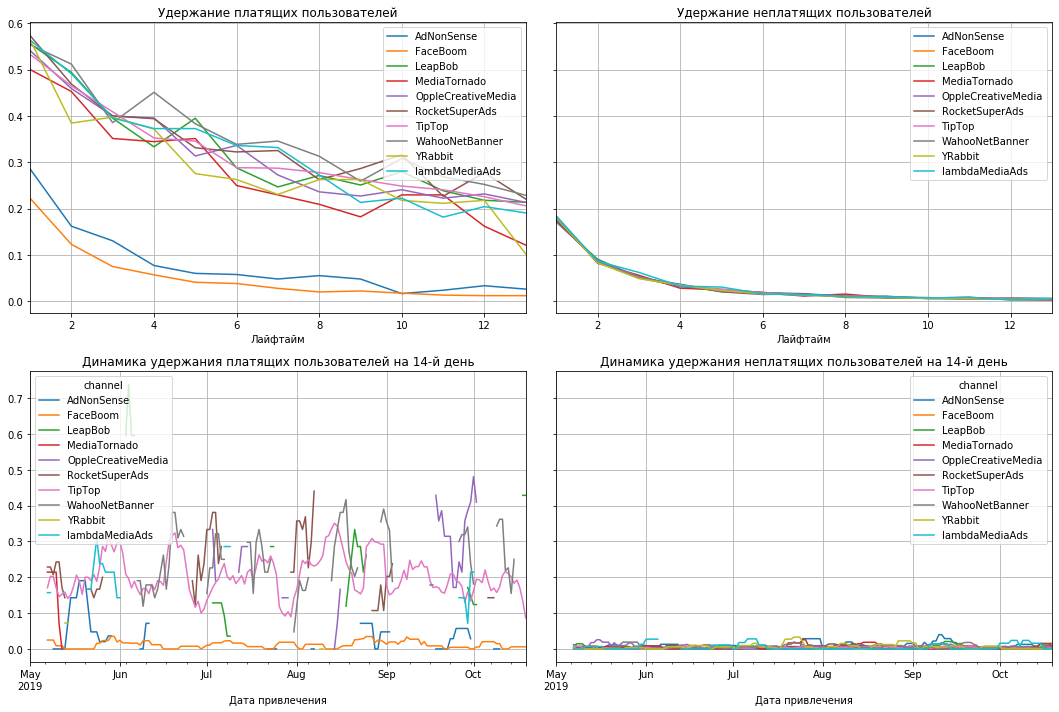

In [76]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Самое низкое удержание пользователей из Faceboom и AdNonSense. Удержание пользователей из остальных источников значительно лучше, однако удержание пользователей из MediaTornado "проваливается" после 6 и до 9 лайфтайма.
Удержание 14-го дня для платящих пользователей из Faceboom тоже стабильно самый низкий показателей удержания.

### Вывод

- В целом реклама не окупается. В бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, а анализ показывает, что к концу второй недели потраченные на рекламу средства возвращаются в компанию только на 80%.

- Окупаемость рекламы снижают каналы TipTop, FaceBoom и АdNonSense. У АdNonSense плохая конверсия, а у Faceboom наоборот конверсия самая хорошая, но явные проблемы с удержанием. А TipTop самый дорогой, в чем скорее всего и кроется причина его столь низкой окупаемости. Конверсия у пользователей TipTop ниже, чем у Faceboom, при этом стоимость привлечения выше.
- Из стран не окупаются только пользователи США, при этом стоимость их привлечения выше чем для других стран. Они очень хорошо конвертируются, но при этом очень плохо удерживаются. Стоит обратить внимание на удержание этих пользователей, возможно им мешает какая-то техническая ошибка в приложении.

## Вывод

Причины неэффективности привлечения пользователей и рекомендации по их устранению:
- крупные вложения в источник привлечения TipTop не показал хороших результатов. Он стабильно не окупался, так же как и FaceBoom и АdNonSense, в которые было меньше вложений.
- единственная страна, пользователи которой не окупаются - США. Самые крупные вложения - именно на привлечение пользователей из США. Но эти пользователи лучше всех конвертируются, но плохо удерживаются, возможно причина в работе приложения для этих пользователей.
- следует разобраться в причинах увеличения бюджета в TipTop, возможно был закуплен слишком дорогой трафик, который можно снизить. Обратить внимание на стоимость рекламы в FaceBoom и АdNonSense, рассмотреть возможность снижения затрат. 
- проверить работу приложения для пользователей из США.
